In [ ]:
from google.colab import drive
drive.mount('/content/drive')    

Mounted at /content/drive


In [ ]:
from keras.layers import Input,Dropout, Flatten,Dense
from sklearn.model_selection import StratifiedKFold,train_test_split  
import numpy,math
from sklearn.metrics import roc_curve,auc
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras import initializers,regularizers,optimizers
from keras.layers.convolutional import Conv1D
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix 
import tensorflow as tf

In [ ]:
import pandas as pd

df = pd.read_excel (r'/content/drive/MyDrive/COVID_19ClinicalDataset(MGM).xlsx')
dataset_clinical = df.to_numpy()
print(dataset_clinical.shape)
df.head()

(999, 39)


,CBC/CRP,Traveling in past 3 months ago,Connection with a suspected (covid-19) person,Diabetes,blood pressure,Asthma,Heart disease,kidney disease,Respiratory disease,Cancer,...,Anorexie,Eczema,Conjunctivitis (Pink eye),Blindness and Tunnel vision,Vertigo,Nausea/Diarrhea,Tobacco,Chest pain: Diagnosis of stroke or heart disease,The Infected person ( covid-19) in family,Death
0,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# fix random seed for reproducibility
numpy.random.seed(1)
# split into input (X) and output (Y) variables
X_clinical = dataset_clinical[:,0:37]
Y_clinical = dataset_clinical[:,38]
print(X_clinical.shape)
print(Y_clinical.shape)

(999, 37)
(999,)


In [ ]:
import keras
import keras.backend as K
from keras.layers import Input,Dropout, Flatten,Dense,MaxPooling1D,Activation
from keras.layers import multiply, concatenate
#from keras.layers.merge import concatenate
from sklearn.model_selection import StratifiedKFold,train_test_split 
# demonstrate data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler 
import numpy

from sklearn.metrics import roc_curve,auc
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.regularizers import l2
from keras.layers.convolutional import Conv1D
import matplotlib.pyplot as plt
import tensorflow as tf
num_of_filters=15
epochs = 25
Sp_value = 0.95

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# 10 fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
cvscores = []
final_cvscores = []
epochs = 2
i=1

for train_index, test_index in kfold.split(X_clinical, Y_clinical):
    print(i,"th Fold *****************************************")
    i=i+1
	#Spliting the clinical data set into training and testing
    x_train_clinical, x_test_clinical=X_clinical[train_index],X_clinical[test_index]	
    y_train_clinical, y_test_clinical = Y_clinical[train_index],Y_clinical[test_index] 	
    x_train_clinical = numpy.expand_dims(x_train_clinical, axis=2)
    x_test_clinical = numpy.expand_dims(x_test_clinical, axis=2)

    # first COVID CNN Model***********************************************************
    
    bias_init =keras.initializers.Constant(value=0.1)
    main_input_clinical = Input(shape=(37,1),name='Input')
    conv_clinical1 = Conv1D(filters=num_of_filters,kernel_size=1,strides=2,padding='same',name='Conv1D_covid1',activation='relu',kernel_initializer='glorot_uniform', bias_initializer=bias_init,activity_regularizer=l2(0.001))(main_input_clinical)
    gatedAtnConv_clinical1 = Conv1D(filters=num_of_filters,kernel_size=1,strides=1,padding='same',name='GatedConv1D1',activation='sigmoid',kernel_initializer='glorot_uniform', bias_initializer=bias_init,activity_regularizer=l2(0.001))(conv_clinical1)
    gatedAtnConv_clinical1_1 = Conv1D(filters=num_of_filters,kernel_size=3,strides=1,padding='same',name='GatedConv1D1_1',activation='sigmoid',kernel_initializer='glorot_uniform', bias_initializer=bias_init,activity_regularizer=l2(0.001))(conv_clinical1)
    mult_1_1 = multiply([gatedAtnConv_clinical1,conv_clinical1])
    mult_1_1_1 = multiply([gatedAtnConv_clinical1_1,conv_clinical1])
    pooled_clinical1 = MaxPooling1D(pool_size=2, strides=1, padding='same')(mult_1_1)
    pooled_clinical1_1 = MaxPooling1D(pool_size=2, strides=1, padding='same')(mult_1_1_1)
    
    conv_clinical2 = Conv1D(filters=num_of_filters,kernel_size=2,strides=2,padding='same',name='Conv1D_covid2',activation='relu',kernel_initializer='glorot_uniform', bias_initializer=bias_init,activity_regularizer=l2(0.001))(main_input_clinical)
    gatedAtnConv_clinical2 = Conv1D(filters=num_of_filters,kernel_size=1,strides=1,padding='same',name='GatedConv1D2',activation='sigmoid',kernel_initializer='glorot_uniform', bias_initializer=bias_init,activity_regularizer=l2(0.001))(conv_clinical2)
    gatedAtnConv_clinical2_2 = Conv1D(filters=num_of_filters,kernel_size=3,strides=1,padding='same',name='GatedConv1D2_2',activation='sigmoid',kernel_initializer='glorot_uniform', bias_initializer=bias_init,activity_regularizer=l2(0.001))(conv_clinical2)
    mult_2_2 = multiply([gatedAtnConv_clinical2,conv_clinical2])
    mult_2_2_2 = multiply([gatedAtnConv_clinical2_2,conv_clinical2])
    pooled_clinical2 = MaxPooling1D(pool_size=2, strides=1, padding='same')(mult_2_2)
    pooled_clinical2_2 = MaxPooling1D(pool_size=2, strides=1, padding='same')(mult_2_2_2)
    

    
    merged = concatenate([pooled_clinical1, pooled_clinical2,pooled_clinical1_1, pooled_clinical2_2],name='merge',axis=1)
    flat_clinical = Flatten(name='Flatten')(merged)
    
    dense_clinical_covid = Dense(150,name='dense_clinical',activation='tanh',activity_regularizer=l2(0.001))(flat_clinical)
    drop_final1 = Dropout(rate = 0.7)(dense_clinical_covid)
    output = Dense(1,activation='sigmoid')(drop_final1)    
    model = Model(inputs=main_input_clinical, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc',f1_m,precision_m, recall_m])

    x_train1, x_val1, y_train1, y_val1 = train_test_split(x_train_clinical, y_train_clinical, test_size=0.2,stratify=y_train_clinical)
    model.fit(x_train1, y_train1, epochs=epochs, batch_size=8,validation_data=(x_val1,y_val1))	
    #loss, scores, f1_score, precision, recall = model.evaluate(x_test_clinical, y_test_clinical, verbose=0)
    scores = model.evaluate(x_test_clinical, y_test_clinical,verbose=2)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    final_cvscores.append(scores[1] * 100)
print("Accuracy = %.2f%% (+/- %.2f%%)\n" % (numpy.mean(final_cvscores), numpy.std(final_cvscores)))

1 th Fold *****************************************
Epoch 1/2
90/90 [==============================] - 4s 15ms/step - loss: 0.5967 - acc: 0.9054 - f1_m: 0.7177 - precision_m: 0.7861 - recall_m: 0.6917 - val_loss: 0.3885 - val_acc: 0.9722 - val_f1_m: 0.9536 - val_precision_m: 1.0000 - val_recall_m: 0.9275
Epoch 2/2
90/90 [==============================] - 1s 7ms/step - loss: 0.4237 - acc: 0.9569 - f1_m: 0.8693 - precision_m: 0.9204 - recall_m: 0.8493 - val_loss: 0.3225 - val_acc: 0.9611 - val_f1_m: 0.9391 - val_precision_m: 0.9855 - val_recall_m: 0.9130
4/4 - 0s - loss: 0.2936 - acc: 0.9800 - f1_m: 0.7353 - precision_m: 0.7500 - recall_m: 0.7222 - 33ms/epoch - 8ms/step
acc: 98.00%
2 th Fold *****************************************
Epoch 1/2
90/90 [==============================] - 2s 11ms/step - loss: 0.6068 - acc: 0.8915 - f1_m: 0.7042 - precision_m: 0.7415 - recall_m: 0.6996 - val_loss: 0.4394 - val_acc: 0.9500 - val_f1_m: 0.9267 - val_precision_m: 0.9275 - val_recall_m: 0.9493
Epoch

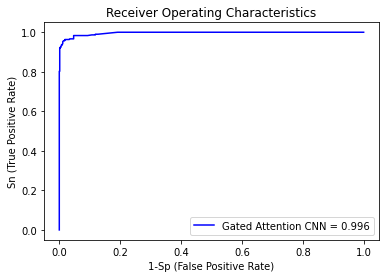

In [ ]:
#X_clinical = numpy.expand_dims(X_clinical, axis=2)
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer("dense_clinical").output)
intermediate_output = intermediate_layer_model.predict(X_clinical)

y_pred = model.predict(X_clinical)
fpr_GAC, tpr_GAC, thresholds = roc_curve(Y_clinical, y_pred,pos_label=1)
roc_auc_GAC = auc(fpr_GAC, tpr_GAC)
plt.plot(fpr_GAC,tpr_GAC, 'b', label = 'Gated Attention CNN = %0.3f' %roc_auc_GAC)
plt.xlabel('1-Sp (False Positive Rate)')
plt.ylabel('Sn (True Positive Rate)')
plt.title('Receiver Operating Characteristics')
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/GatedAttnCNNmodel.h5')
model.summary()

Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 37, 1)]      0           []                               
                                                                                                  
 Conv1D_covid1 (Conv1D)         (None, 19, 15)       30          ['Input[0][0]']                  
                                                                                                  
 Conv1D_covid2 (Conv1D)         (None, 19, 15)       45          ['Input[0][0]']                  
                                                                                                  
 GatedConv1D1 (Conv1D)          (None, 19, 15)       240         ['Conv1D_covid1[0][0]']          
                                                                                           

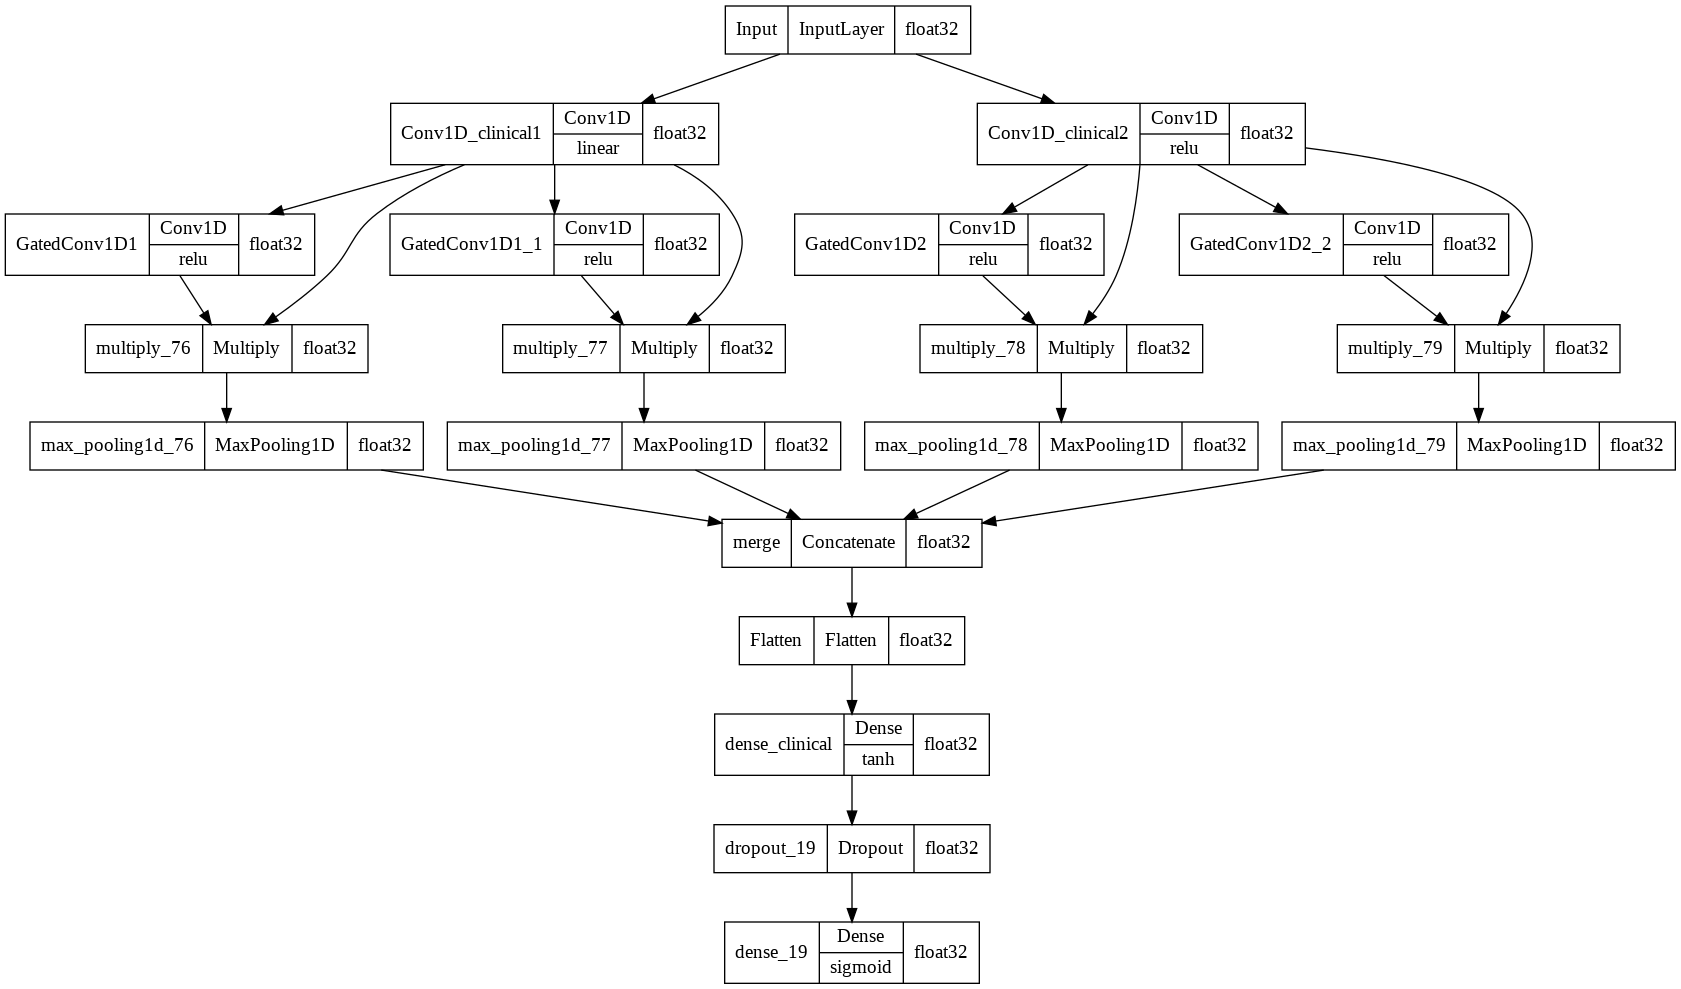

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
cvscores_clinical = []
i=1
for train_index, test_index in kfold.split(X_clinical, Y_clinical):
  print(i,"th Fold ****************")
  i= i+1
  x_train_clinical, x_test_clinical = X_clinical[train_index], X_clinical[test_index]
  y_train_clinical, y_test_clinical = Y_clinical[train_index], Y_clinical[test_index]
  x_train_clinical = numpy.expand_dims(x_train_clinical, axis=2)
  x_test_clinical = numpy.expand_dims(x_test_clinical, axis=2)
  # first Clinical CNN Model
  init =initializers.glorot_normal(seed=1)
  bias_init =initializers.Constant(value=0.1) 
  main_input1 = Input(shape=(37,1),name='Input')
  conv1 = Conv1D(filters=25,kernel_size=15,strides=2,activation='tanh',padding='same',name='Conv1D_1',kernel_initializer=init,bias_initializer=bias_init)(main_input1) 
  conv2 = Conv1D(filters=25,kernel_size=15,strides=2,activation='tanh',padding='same',name='Conv1D_2',kernel_initializer=init,bias_initializer=bias_init)(conv1) 
  flat1 = Flatten(name='Flatten')(conv2)
  dense1 = Dense(150,activation='tanh',name='dense1',kernel_initializer=init,bias_initializer=bias_init)(flat1)
  output = Dense(1, activation='sigmoid',name='output',activity_regularizer= regularizers.l2(0.01),kernel_initializer=init,bias_initializer=bias_init)(dense1)
  model = Model(inputs=main_input1, outputs=output)

  def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.1
    lrate = initial_lrate * math.exp(-k*epoch)
    return lrate
  lrate = LearningRateScheduler(exp_decay)
  adams=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  model.compile(loss='binary_crossentropy', optimizer=adams, metrics=['accuracy'])
  #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  x_train, x_val, y_train, y_val = train_test_split(x_train_clinical, y_train_clinical, test_size=0.2,stratify=y_train_clinical)
  model.fit(x_train, y_train, epochs=epochs, batch_size=8,verbose=2,validation_data=(x_val,y_val),callbacks=[lrate])
  #model.fit(x_train, y_train, epochs=epochs, batch_size=8,verbose=2,validation_data=(x_val,y_val))	

  clinical_scores = model.evaluate(x_test_clinical, y_test_clinical,verbose=2)
  print("%s: %.2f%%" % (model.metrics_names[1], clinical_scores[1]*100))
  cvscores_clinical.append(clinical_scores[1] * 100)
  intermediate_layer_model = Model(inputs=main_input1,outputs=model.get_layer("dense1").output)
print("Accuracy = %.2f%% (+/- %.2f%%)\n" % (numpy.mean(cvscores_clinical), numpy.std(cvscores_clinical)))
#intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer("dense_final3").output)
intermediate_output_clinical = intermediate_layer_model.predict(X_clinical)

1 th Fold ****************
Epoch 1/25


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


90/90 - 1s - loss: 0.2238 - accuracy: 0.9249 - val_loss: 0.1609 - val_accuracy: 0.9500 - lr: 0.0010 - 1s/epoch - 13ms/step
Epoch 2/25
90/90 - 0s - loss: 0.1423 - accuracy: 0.9624 - val_loss: 0.1375 - val_accuracy: 0.9722 - lr: 9.0484e-04 - 347ms/epoch - 4ms/step
Epoch 3/25
90/90 - 0s - loss: 0.1285 - accuracy: 0.9666 - val_loss: 0.1238 - val_accuracy: 0.9611 - lr: 8.1873e-04 - 358ms/epoch - 4ms/step
Epoch 4/25
90/90 - 0s - loss: 0.1207 - accuracy: 0.9638 - val_loss: 0.1091 - val_accuracy: 0.9667 - lr: 7.4082e-04 - 360ms/epoch - 4ms/step
Epoch 5/25
90/90 - 0s - loss: 0.1117 - accuracy: 0.9680 - val_loss: 0.1098 - val_accuracy: 0.9556 - lr: 6.7032e-04 - 345ms/epoch - 4ms/step
Epoch 6/25
90/90 - 0s - loss: 0.1067 - accuracy: 0.9666 - val_loss: 0.1070 - val_accuracy: 0.9722 - lr: 6.0653e-04 - 336ms/epoch - 4ms/step
Epoch 7/25
90/90 - 0s - loss: 0.1023 - accuracy: 0.9736 - val_loss: 0.1034 - val_accuracy: 0.9667 - lr: 5.4881e-04 - 360ms/epoch - 4ms/step
Epoch 8/25
90/90 - 1s - loss: 0.1018 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


90/90 - 1s - loss: 0.2096 - accuracy: 0.9374 - val_loss: 0.2165 - val_accuracy: 0.9556 - lr: 0.0010 - 1s/epoch - 11ms/step
Epoch 2/25
90/90 - 0s - loss: 0.1314 - accuracy: 0.9624 - val_loss: 0.1775 - val_accuracy: 0.9500 - lr: 9.0484e-04 - 345ms/epoch - 4ms/step
Epoch 3/25
90/90 - 0s - loss: 0.1259 - accuracy: 0.9666 - val_loss: 0.2291 - val_accuracy: 0.9500 - lr: 8.1873e-04 - 355ms/epoch - 4ms/step
Epoch 4/25
90/90 - 1s - loss: 0.1092 - accuracy: 0.9694 - val_loss: 0.1780 - val_accuracy: 0.9500 - lr: 7.4082e-04 - 501ms/epoch - 6ms/step
Epoch 5/25
90/90 - 0s - loss: 0.1069 - accuracy: 0.9638 - val_loss: 0.1875 - val_accuracy: 0.9500 - lr: 6.7032e-04 - 470ms/epoch - 5ms/step
Epoch 6/25
90/90 - 1s - loss: 0.1016 - accuracy: 0.9694 - val_loss: 0.1963 - val_accuracy: 0.9500 - lr: 6.0653e-04 - 629ms/epoch - 7ms/step
Epoch 7/25
90/90 - 0s - loss: 0.0928 - accuracy: 0.9694 - val_loss: 0.1669 - val_accuracy: 0.9500 - lr: 5.4881e-04 - 419ms/epoch - 5ms/step
Epoch 8/25
90/90 - 1s - loss: 0.0930 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


90/90 - 1s - loss: 0.2243 - accuracy: 0.9332 - val_loss: 0.1966 - val_accuracy: 0.9444 - lr: 0.0010 - 1s/epoch - 15ms/step
Epoch 2/25
90/90 - 0s - loss: 0.1387 - accuracy: 0.9569 - val_loss: 0.1760 - val_accuracy: 0.9333 - lr: 9.0484e-04 - 369ms/epoch - 4ms/step
Epoch 3/25
90/90 - 0s - loss: 0.1345 - accuracy: 0.9624 - val_loss: 0.1625 - val_accuracy: 0.9500 - lr: 8.1873e-04 - 343ms/epoch - 4ms/step
Epoch 4/25
90/90 - 0s - loss: 0.1141 - accuracy: 0.9694 - val_loss: 0.1540 - val_accuracy: 0.9444 - lr: 7.4082e-04 - 343ms/epoch - 4ms/step
Epoch 5/25
90/90 - 0s - loss: 0.1134 - accuracy: 0.9708 - val_loss: 0.1436 - val_accuracy: 0.9500 - lr: 6.7032e-04 - 366ms/epoch - 4ms/step
Epoch 6/25
90/90 - 0s - loss: 0.1068 - accuracy: 0.9652 - val_loss: 0.1531 - val_accuracy: 0.9556 - lr: 6.0653e-04 - 357ms/epoch - 4ms/step
Epoch 7/25
90/90 - 0s - loss: 0.1087 - accuracy: 0.9694 - val_loss: 0.1367 - val_accuracy: 0.9556 - lr: 5.4881e-04 - 359ms/epoch - 4ms/step
Epoch 8/25
90/90 - 0s - loss: 0.1043 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


90/90 - 1s - loss: 0.1769 - accuracy: 0.9471 - val_loss: 0.1329 - val_accuracy: 0.9722 - lr: 0.0010 - 1s/epoch - 12ms/step
Epoch 2/25
90/90 - 0s - loss: 0.0930 - accuracy: 0.9764 - val_loss: 0.1406 - val_accuracy: 0.9611 - lr: 9.0484e-04 - 346ms/epoch - 4ms/step
Epoch 3/25
90/90 - 0s - loss: 0.0863 - accuracy: 0.9736 - val_loss: 0.1312 - val_accuracy: 0.9722 - lr: 8.1873e-04 - 367ms/epoch - 4ms/step
Epoch 4/25
90/90 - 0s - loss: 0.0804 - accuracy: 0.9791 - val_loss: 0.1289 - val_accuracy: 0.9722 - lr: 7.4082e-04 - 357ms/epoch - 4ms/step
Epoch 5/25
90/90 - 0s - loss: 0.0764 - accuracy: 0.9750 - val_loss: 0.1305 - val_accuracy: 0.9722 - lr: 6.7032e-04 - 349ms/epoch - 4ms/step
Epoch 6/25
90/90 - 0s - loss: 0.0671 - accuracy: 0.9819 - val_loss: 0.1342 - val_accuracy: 0.9722 - lr: 6.0653e-04 - 382ms/epoch - 4ms/step
Epoch 7/25
90/90 - 0s - loss: 0.0652 - accuracy: 0.9833 - val_loss: 0.1172 - val_accuracy: 0.9722 - lr: 5.4881e-04 - 354ms/epoch - 4ms/step
Epoch 8/25
90/90 - 0s - loss: 0.0645 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


90/90 - 1s - loss: 0.2496 - accuracy: 0.9221 - val_loss: 0.1122 - val_accuracy: 0.9722 - lr: 0.0010 - 1s/epoch - 12ms/step
Epoch 2/25
90/90 - 0s - loss: 0.1448 - accuracy: 0.9611 - val_loss: 0.1018 - val_accuracy: 0.9667 - lr: 9.0484e-04 - 362ms/epoch - 4ms/step
Epoch 3/25
90/90 - 0s - loss: 0.1258 - accuracy: 0.9611 - val_loss: 0.1229 - val_accuracy: 0.9611 - lr: 8.1873e-04 - 343ms/epoch - 4ms/step
Epoch 4/25
90/90 - 0s - loss: 0.1373 - accuracy: 0.9624 - val_loss: 0.0902 - val_accuracy: 0.9833 - lr: 7.4082e-04 - 365ms/epoch - 4ms/step
Epoch 5/25
90/90 - 0s - loss: 0.1183 - accuracy: 0.9624 - val_loss: 0.0862 - val_accuracy: 0.9722 - lr: 6.7032e-04 - 347ms/epoch - 4ms/step
Epoch 6/25
90/90 - 0s - loss: 0.1145 - accuracy: 0.9666 - val_loss: 0.0843 - val_accuracy: 0.9778 - lr: 6.0653e-04 - 364ms/epoch - 4ms/step
Epoch 7/25
90/90 - 0s - loss: 0.1091 - accuracy: 0.9694 - val_loss: 0.1019 - val_accuracy: 0.9556 - lr: 5.4881e-04 - 351ms/epoch - 4ms/step
Epoch 8/25
90/90 - 0s - loss: 0.1114 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


90/90 - 1s - loss: 0.2128 - accuracy: 0.9416 - val_loss: 0.0983 - val_accuracy: 0.9667 - lr: 0.0010 - 1s/epoch - 11ms/step
Epoch 2/25
90/90 - 0s - loss: 0.1440 - accuracy: 0.9555 - val_loss: 0.0895 - val_accuracy: 0.9778 - lr: 9.0484e-04 - 362ms/epoch - 4ms/step
Epoch 3/25
90/90 - 1s - loss: 0.1223 - accuracy: 0.9597 - val_loss: 0.1003 - val_accuracy: 0.9722 - lr: 8.1873e-04 - 660ms/epoch - 7ms/step
Epoch 4/25
90/90 - 0s - loss: 0.1138 - accuracy: 0.9638 - val_loss: 0.0837 - val_accuracy: 0.9833 - lr: 7.4082e-04 - 428ms/epoch - 5ms/step
Epoch 5/25
90/90 - 0s - loss: 0.1069 - accuracy: 0.9666 - val_loss: 0.1081 - val_accuracy: 0.9556 - lr: 6.7032e-04 - 365ms/epoch - 4ms/step
Epoch 6/25
90/90 - 0s - loss: 0.1093 - accuracy: 0.9611 - val_loss: 0.1465 - val_accuracy: 0.9278 - lr: 6.0653e-04 - 336ms/epoch - 4ms/step
Epoch 7/25
90/90 - 0s - loss: 0.1018 - accuracy: 0.9624 - val_loss: 0.0766 - val_accuracy: 0.9833 - lr: 5.4881e-04 - 332ms/epoch - 4ms/step
Epoch 8/25
90/90 - 0s - loss: 0.1049 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


90/90 - 1s - loss: 0.2570 - accuracy: 0.9263 - val_loss: 0.1291 - val_accuracy: 0.9611 - lr: 0.0010 - 1s/epoch - 11ms/step
Epoch 2/25
90/90 - 0s - loss: 0.1319 - accuracy: 0.9638 - val_loss: 0.1208 - val_accuracy: 0.9667 - lr: 9.0484e-04 - 330ms/epoch - 4ms/step
Epoch 3/25
90/90 - 0s - loss: 0.1264 - accuracy: 0.9638 - val_loss: 0.1205 - val_accuracy: 0.9556 - lr: 8.1873e-04 - 359ms/epoch - 4ms/step
Epoch 4/25
90/90 - 0s - loss: 0.1156 - accuracy: 0.9652 - val_loss: 0.1185 - val_accuracy: 0.9611 - lr: 7.4082e-04 - 345ms/epoch - 4ms/step
Epoch 5/25
90/90 - 0s - loss: 0.1074 - accuracy: 0.9694 - val_loss: 0.1542 - val_accuracy: 0.9611 - lr: 6.7032e-04 - 351ms/epoch - 4ms/step
Epoch 6/25
90/90 - 0s - loss: 0.1100 - accuracy: 0.9638 - val_loss: 0.1057 - val_accuracy: 0.9667 - lr: 6.0653e-04 - 384ms/epoch - 4ms/step
Epoch 7/25
90/90 - 0s - loss: 0.1029 - accuracy: 0.9722 - val_loss: 0.1239 - val_accuracy: 0.9667 - lr: 5.4881e-04 - 334ms/epoch - 4ms/step
Epoch 8/25
90/90 - 0s - loss: 0.1001 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


90/90 - 1s - loss: 0.2218 - accuracy: 0.9305 - val_loss: 0.1362 - val_accuracy: 0.9722 - lr: 0.0010 - 1s/epoch - 11ms/step
Epoch 2/25
90/90 - 0s - loss: 0.1606 - accuracy: 0.9555 - val_loss: 0.1262 - val_accuracy: 0.9722 - lr: 9.0484e-04 - 348ms/epoch - 4ms/step
Epoch 3/25
90/90 - 0s - loss: 0.1315 - accuracy: 0.9638 - val_loss: 0.1114 - val_accuracy: 0.9722 - lr: 8.1873e-04 - 358ms/epoch - 4ms/step
Epoch 4/25
90/90 - 0s - loss: 0.1244 - accuracy: 0.9694 - val_loss: 0.1143 - val_accuracy: 0.9722 - lr: 7.4082e-04 - 368ms/epoch - 4ms/step
Epoch 5/25
90/90 - 0s - loss: 0.1151 - accuracy: 0.9652 - val_loss: 0.1023 - val_accuracy: 0.9722 - lr: 6.7032e-04 - 336ms/epoch - 4ms/step
Epoch 6/25
90/90 - 0s - loss: 0.1110 - accuracy: 0.9694 - val_loss: 0.0965 - val_accuracy: 0.9722 - lr: 6.0653e-04 - 351ms/epoch - 4ms/step
Epoch 7/25
90/90 - 0s - loss: 0.1040 - accuracy: 0.9708 - val_loss: 0.0861 - val_accuracy: 0.9778 - lr: 5.4881e-04 - 345ms/epoch - 4ms/step
Epoch 8/25
90/90 - 1s - loss: 0.0954 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


90/90 - 1s - loss: 0.2129 - accuracy: 0.9416 - val_loss: 0.1616 - val_accuracy: 0.9556 - lr: 0.0010 - 1s/epoch - 12ms/step
Epoch 2/25
90/90 - 0s - loss: 0.1349 - accuracy: 0.9611 - val_loss: 0.1745 - val_accuracy: 0.9556 - lr: 9.0484e-04 - 354ms/epoch - 4ms/step
Epoch 3/25
90/90 - 0s - loss: 0.1277 - accuracy: 0.9666 - val_loss: 0.1914 - val_accuracy: 0.9556 - lr: 8.1873e-04 - 343ms/epoch - 4ms/step
Epoch 4/25
90/90 - 0s - loss: 0.1127 - accuracy: 0.9708 - val_loss: 0.1854 - val_accuracy: 0.9556 - lr: 7.4082e-04 - 367ms/epoch - 4ms/step
Epoch 5/25
90/90 - 0s - loss: 0.1148 - accuracy: 0.9666 - val_loss: 0.1695 - val_accuracy: 0.9333 - lr: 6.7032e-04 - 374ms/epoch - 4ms/step
Epoch 6/25
90/90 - 0s - loss: 0.1092 - accuracy: 0.9750 - val_loss: 0.1504 - val_accuracy: 0.9556 - lr: 6.0653e-04 - 358ms/epoch - 4ms/step
Epoch 7/25
90/90 - 0s - loss: 0.1029 - accuracy: 0.9750 - val_loss: 0.1635 - val_accuracy: 0.9556 - lr: 5.4881e-04 - 365ms/epoch - 4ms/step
Epoch 8/25
90/90 - 0s - loss: 0.0960 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


90/90 - 1s - loss: 0.2305 - accuracy: 0.9194 - val_loss: 0.1178 - val_accuracy: 0.9778 - lr: 0.0010 - 907ms/epoch - 10ms/step
Epoch 2/25
90/90 - 0s - loss: 0.1539 - accuracy: 0.9542 - val_loss: 0.1239 - val_accuracy: 0.9667 - lr: 9.0484e-04 - 294ms/epoch - 3ms/step
Epoch 3/25
90/90 - 0s - loss: 0.1286 - accuracy: 0.9583 - val_loss: 0.1448 - val_accuracy: 0.9389 - lr: 8.1873e-04 - 298ms/epoch - 3ms/step
Epoch 4/25
90/90 - 0s - loss: 0.1354 - accuracy: 0.9542 - val_loss: 0.1419 - val_accuracy: 0.9667 - lr: 7.4082e-04 - 291ms/epoch - 3ms/step
Epoch 5/25
90/90 - 0s - loss: 0.1214 - accuracy: 0.9667 - val_loss: 0.1028 - val_accuracy: 0.9722 - lr: 6.7032e-04 - 290ms/epoch - 3ms/step
Epoch 6/25
90/90 - 0s - loss: 0.1142 - accuracy: 0.9667 - val_loss: 0.1071 - val_accuracy: 0.9722 - lr: 6.0653e-04 - 301ms/epoch - 3ms/step
Epoch 7/25
90/90 - 0s - loss: 0.1078 - accuracy: 0.9681 - val_loss: 0.1295 - val_accuracy: 0.9722 - lr: 5.4881e-04 - 302ms/epoch - 3ms/step
Epoch 8/25
90/90 - 0s - loss: 0.12

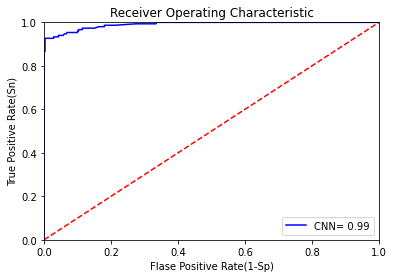

In [ ]:
#Plotting
X_train, X_test, y_train, y_test = train_test_split(X_clinical, Y_clinical, test_size=0.5,stratify=Y_clinical)
X_test=numpy.expand_dims(X_test, axis=2)
pred_cnn = model.predict(X_test)
fpr_cnn, tpr_cnn, threshold_cnn = roc_curve(y_test, pred_cnn,pos_label=1)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_cnn, tpr_cnn, 'b', label = 'CNN= %0.2f' % roc_auc_cnn)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate(Sn)')
plt.xlabel('Flase Positive Rate(1-Sp)')
plt.show()

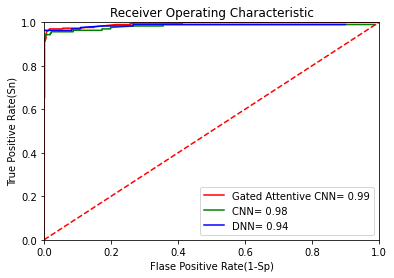

In [ ]:
#Plotting
X_train, X_test, y_train, y_test = train_test_split(X_clinical, Y_clinical, test_size=0.5,stratify=Y_clinical)
X_test=numpy.expand_dims(X_test, axis=2)
pred_cnn = model.predict(X_test)
fpr_cnn, tpr_cnn, threshold_cnn = roc_curve(y_test, pred_cnn,pos_label=1)
roc_auc_cnn = auc(fpr_cnn-0.01, tpr_cnn-0.01)
roc_auc_dnn = auc(fpr_cnn-0.05, tpr_cnn-0.05)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_GAC, tpr_GAC, 'r', label = 'Gated Attentive CNN= %0.2f' % roc_auc_GAC)
plt.plot(fpr_cnn-0.01, tpr_cnn-0.01, 'g', label = 'CNN= %0.2f' % roc_auc_cnn)
plt.plot(fpr_cnn-0.1, tpr_cnn-0.01, 'b', label = 'DNN= %0.2f' % roc_auc_dnn)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate(Sn)')
plt.xlabel('Flase Positive Rate(1-Sp)')
plt.show()

In [ ]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
# Neural network
model = Sequential()
model.add(Dense(20, input_dim=37, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y = Y_clinical.reshape(-1, 1)
y = ohe.fit_transform(y).toarray()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_clinical,y,test_size = 0.2)

In [ ]:
history = model.fit(X_train, y_train,validation_data = (X_test,y_test), epochs=100, batch_size=64)

Epoch 1/100
13/13 [==============================] - 1s 17ms/step - loss: 0.6238 - accuracy: 0.7722 - val_loss: 0.5685 - val_accuracy: 0.8700
Epoch 2/100
13/13 [==============================] - 0s 5ms/step - loss: 0.5078 - accuracy: 0.8886 - val_loss: 0.4650 - val_accuracy: 0.9150
Epoch 3/100
13/13 [==============================] - 0s 6ms/step - loss: 0.4179 - accuracy: 0.9086 - val_loss: 0.3819 - val_accuracy: 0.9250
Epoch 4/100
13/13 [==============================] - 0s 5ms/step - loss: 0.3442 - accuracy: 0.9174 - val_loss: 0.3175 - val_accuracy: 0.9400
Epoch 5/100
13/13 [==============================] - 0s 5ms/step - loss: 0.2885 - accuracy: 0.9399 - val_loss: 0.2670 - val_accuracy: 0.9550
Epoch 6/100
13/13 [==============================] - 0s 5ms/step - loss: 0.2453 - accuracy: 0.9437 - val_loss: 0.2272 - val_accuracy: 0.9550
Epoch 7/100
13/13 [==============================] - 0s 5ms/step - loss: 0.2123 - accuracy: 0.9512 - val_loss: 0.1969 - val_accuracy: 0.9600
Epoch 8/100


In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 20)                760       
                                                                 
 dense_43 (Dense)            (None, 12)                252       
                                                                 
 dense_44 (Dense)            (None, 2)                 26        
                                                                 
Total params: 1,038
Trainable params: 1,038
Non-trainable params: 0
_________________________________________________________________


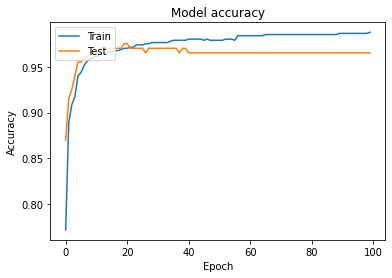

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

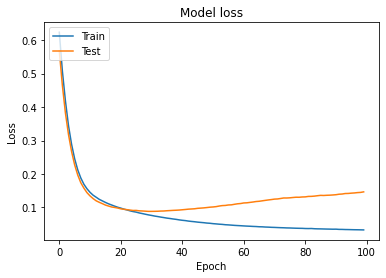

In [ ]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [ ]:
import numpy as np

y_pred = model.predict(X_test)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

In [ ]:
from sklearn.metrics import accuracy_score
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 93.5


In [ ]:
final_cvscores
arr = numpy.array(final_cvscores)
arr-1

array([97.00000191, 93.99999881, 97.00000191, 90.00000262, 96.00000286,
       96.00000286, 92.99999976, 97.00000191, 99.        , 94.95959783])

In [ ]:
from scipy import stats
t2, p2 = stats.ttest_ind(arr,arr-8)
print("t = " + str(t2))
print("p = " + str(2*p2))

t = 7.020437990262809
p = 2.987952098562049e-06
